# Heuristics

In [19]:
using Dates, JuMP, Gurobi, Plots, Logging, LaTeXStrings

In [20]:
push!(LOAD_PATH, dirname(@__DIR__))
using ShelfSpaceAllocation

In [21]:
function shelf_space_allocation_model_no_blocks(
        products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps, D_p,
        N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s, H_p, SL,
        w_1, w_2, w_3)
    # Initialize the model
    model = Model()

    # --- Basic Variables ---
    @variable(model, s_p[products] ≥ 0)
    @variable(model, e_p[products] ≥ 0)
    @variable(model, o_s[shelves] ≥ 0)
    @variable(model, n_ps[products, shelves] ≥ 0, Int)
    @variable(model, y_p[products], Bin)

    # Height and weight constraints
    for p in products
        for s in shelves
            if (H_p[p] > H_s[s]) | (M_p[p] > M_s_max[s])
                fix(n_ps[p, s], 0, force=true)
            end
        end
    end

    # --- Objective ---
    @objective(model, Min,
        w_1 * sum(o_s[s] for s in shelves) +
        w_2 * sum(G_p[p] * e_p[p] for p in products) +
        w_3 * sum(L_p[p] * L_s[s] * n_ps[p, s] for p in products for s in shelves)
    )

    # --- Basic constraints ---
    @constraints(model, begin
        [p = products],
        s_p[p] ≤ sum(30 / R_p[p] * P_ps[p, s] * n_ps[p, s] for s in shelves)
        [p = products],
        s_p[p] ≤ D_p[p]
    end)
    @constraint(model, [p = products],
        s_p[p] + e_p[p] == D_p[p])
    @constraint(model, [p = products],
        sum(n_ps[p, s] for s in shelves) ≥ y_p[p])
    @constraints(model, begin
        [p = products],
        N_p_min[p] * y_p[p] ≤ sum(n_ps[p, s] for s in shelves)
        [p = products],
        sum(n_ps[p, s] for s in shelves) ≤ N_p_max[p] * y_p[p]
    end)
    @constraint(model, [s = shelves],
        sum(W_p[p] * n_ps[p, s] for p in products) + o_s[s] == W_s[s])
    
    return model
end

shelf_space_allocation_model_no_blocks (generic function with 1 method)

In [22]:
"""Creates a planogram which visualizes the product placement on the shelves."""
function planogram_no_blocks(products, shelves, blocks, P_b, H_s, H_p, W_p, W_s, SK_p, n_ps, o_s):: Plots.Plot
    block_colors = cgrad(:inferno)
    
    # Initialize the plot
    plt = plot(
        legend=:none,
        background=:lightgray,
        size=(780, 400)
    )

    # Cumulative shelf heights
    y_s = vcat([0], cumsum([H_s[s] for s in shelves]))

    # Draw products
    rect(x, y, w, h) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
    for s in shelves
        x = 0
        for b in blocks
            for p in P_b[b]
                stack = max(min(div(H_s[s], H_p[p]), SK_p[p]), 1)
                for i in 1:n_ps[p, s]
                    y = 0
                    for j in 1:stack
                        plot!(plt, rect(x, y_s[s]+y, W_p[p], H_p[p]), 
                              color=block_colors[b/length(blocks)], 
                        )
                        y += H_p[p]
                    end
                    x += W_p[p]
                end
            end
        end
    end

    # Draw shelves
    for s in shelves
        plot!(plt, [0, W_s[s]], [y_s[s-shelves[1]+1], y_s[s-shelves[1]+1]],
              color=:black)
    end
    plot!(plt, [0, W_s[shelves[end]]], [y_s[end], y_s[end]],
          color=:black, linestyle=:dash)

    return plt
end

planogram_no_blocks

In [23]:
"""Relax-and-fix heuristic."""
function relax_and_fix(
        products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p,
        P_ps, D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
        H_p, SL, block_partitions, w_1, w_2, w_3, optimizer)
    # Remember fixed blocks and values
    relaxed_blocks = block_partitions[2:end]
    # TODO: test fixing related n_ps variables too for faster runtime
    fixed_blocks = []
    z_bs = []
    x_bs = []
    b_bs = []
    model = nothing
    for block in block_partitions
        # Solve the shelf space allocation model with a subset of blocks
        model = shelf_space_allocation_model(
            products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps,
            D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
            H_p, SL, w_1, w_2, w_3)

        # Relaxed values
        for relaxed_block in relaxed_blocks
            for b in relaxed_block
                for s in shelves
                    unset_binary(model.obj_dict[:z_bs][b, s])
                    unset_binary(model.obj_dict[:z_bs_f][b, s])
                    unset_binary(model.obj_dict[:z_bs_l][b, s])
                end
            end
        end

        # Fixed values
        for (i, fixed_block) in enumerate(fixed_blocks)
            for b in fixed_block
                for s in shelves
                    unset_binary(model.obj_dict[:z_bs][b, s])
                    fix(model.obj_dict[:x_bs][b, s], x_bs[i][b, s], force=true)
                    fix(model.obj_dict[:b_bs][b, s], b_bs[i][b, s], force=true)
                    fix(model.obj_dict[:z_bs][b, s], z_bs[i][b, s], force=true)
                end
            end
        end

        optimize!(model, optimizer)

        if termination_status(model) == MOI.INFEASIBLE
            exit()
        end

        # Decrease relaxed blocks
        relaxed_blocks = relaxed_blocks[2:end]

        # TODO: move x_bs as far left as possible without overlapping
        push!(fixed_blocks, block)
        push!(x_bs, value.(model.obj_dict[:x_bs]))
        push!(b_bs, value.(model.obj_dict[:b_bs]))
        push!(z_bs, value.(model.obj_dict[:z_bs]))
    end

    return model
end

relax_and_fix

In [24]:
"""Fix-and-optimize heuristic."""
function fix_and_optimize(
        products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p,
        P_ps, D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
        H_p, SL, z_bs, w_1, w_2, w_3)

    model = shelf_space_allocation_model(
        products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps,
        D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
        H_p, SL, w_1, w_2, w_3)

    for b in blocks
        # Pad with zeros and find 0-1 boundaries using diff
        difference = diff(vcat([0], z_bs[b, :], [0]))
        # Fix a subset of z_bs variables
        i = 1
        while i <= length(difference)
            if abs(difference[i]) == 1
                i += 2
            else
                s = i - 1
                if s > 0
                    unset_binary(model.obj_dict[:z_bs][b, s])
                    fix(model.obj_dict[:z_bs][b, s], z_bs[b, s])
                end
                i += 1
            end
        end
    end

    return model
end

fix_and_optimize

## Parameters

In [25]:
case = "medium"
product_path = joinpath(@__DIR__, "instances", case, "products.csv")
shelf_path = joinpath(@__DIR__, "instances", case, "shelves.csv")
output_dir = joinpath(@__DIR__, "output", case, string(Dates.now()));

In [26]:
parameters = load_parameters(product_path, shelf_path)
(products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps, D_p,
    N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s, H_p, SK_p, SL, 
    empty_space_penalty, shortage_penalty, shelf_up_down_penalty) = parameters;

## Shelf Space Allocation without Blocks

In [27]:
model1 = shelf_space_allocation_model_no_blocks(
    products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps, D_p,
    N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s, H_p, SL,
    empty_space_penalty, shortage_penalty, shelf_up_down_penalty);

In [28]:
optimize!(model1, with_optimizer(
        Gurobi.Optimizer, 
        TimeLimit=1*60, 
        MIPGap=false));

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 1333 rows, 2217 columns and 9068 nonzeros
Variable types: 449 continuous, 1768 integer (221 binary)
Coefficient statistics:
  Matrix range     [9e-01, 4e+02]
  Objective range  [7e-03, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 96983.047000
Presolve removed 681 rows and 659 columns
Presolve time: 0.01s
Presolved: 652 rows, 1558 columns, 5069 nonzeros
Variable types: 53 continuous, 1505 integer (374 binary)

Root relaxation: objective 3.678265e+03, 762 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3678.26502    0   75 96983.0470 3678.26502  96.2%     -    0s
H    0     0                    6704.4790142 3678.26502  45.1%     -    0s
H    0     0                    5

In [29]:
variables = extract_variables(model1)
n_ps = variables[:n_ps]
s_p = variables[:s_p]
o_s = variables[:o_s];

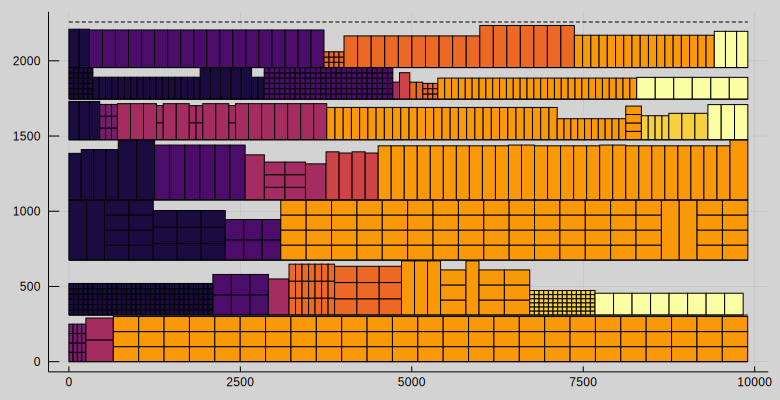

In [30]:
planogram_no_blocks(products, shelves, blocks, P_b, H_s, H_p, W_p, W_s, SK_p, n_ps, o_s)

## Block Partitions

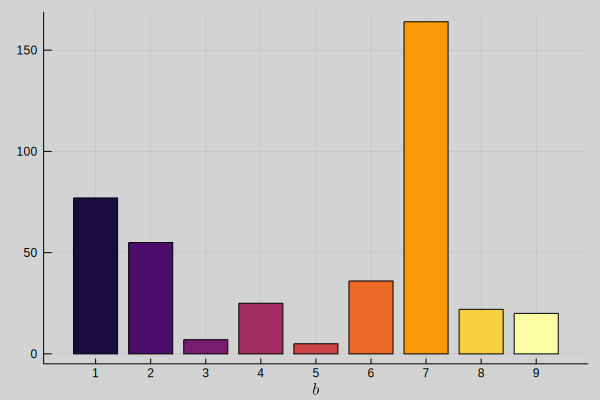

In [31]:
fill_amount(shelves, blocks, P_b, n_ps)

In [32]:
amounts = round.([sum(n_ps[p, s] for s in shelves for p in P_b[b]) for b in blocks])

9-element Array{Float64,1}:
  77.0
  55.0
   7.0
  25.0
   5.0
  36.0
 164.0
  22.0
  20.0

In [33]:
block_indices = reverse(sortperm(amounts))

9-element Array{Int64,1}:
 7
 1
 2
 6
 4
 8
 9
 3
 5

In [34]:
function partition(n, array)
    r = []
    i = 0
    m = div(length(array), n)
    for _ in 1:(m-1)
        push!(r, [array[j+i] for j in 1:n])
        i += n
    end
    push!(r, array[(i+1):end])
    return r
end

partition (generic function with 1 method)

In [35]:
block_partitions = partition(2, block_indices)

4-element Array{Any,1}:
 [7, 1]   
 [2, 6]   
 [4, 8]   
 [9, 3, 5]

## Relax-and-Fix Heuristic

In [37]:
optimizer = with_optimizer(
    Gurobi.Optimizer,
    TimeLimit=5*60,
    MIPFocus=3,
    MIPGap=0.01)

model2 = relax_and_fix(
    products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p,
    P_ps, D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
    H_p, SL, block_partitions, empty_space_penalty, shortage_penalty, 
    shelf_up_down_penalty, optimizer);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 6108 rows, 2640 columns and 25100 nonzeros
Variable types: 740 continuous, 1900 integer (353 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+04]
  Objective range  [7e-03, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 96983.047000
Presolve removed 2759 rows and 779 columns
Presolve time: 0.02s
Presolved: 3349 rows, 1861 columns, 15965 nonzeros
Variable types: 246 continuous, 1615 integer (484 binary)
Presolve removed 208 rows and 208 columns
Presolved: 3141 rows, 1653 columns, 14482 nonzeros


Root relaxation: objective 3.680131e+03, 1971 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3680.13131    0  201 96983.0470 3680.13131  96.2%     -    0s
H    0  

In [38]:
variables = Dict(k => value.(v) for (k, v) in model2.obj_dict)
n_ps = variables[:n_ps]
o_s = variables[:o_s]
b_bs = variables[:b_bs]
x_bs = variables[:x_bs]
z_bs = variables[:z_bs];

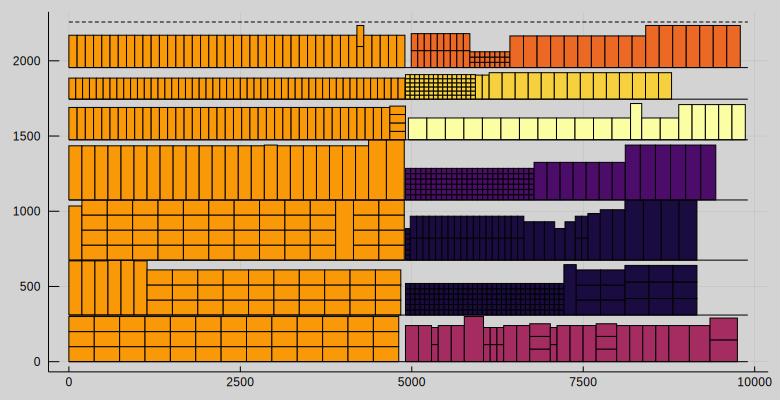

In [39]:
planogram(products, shelves, blocks, P_b, H_s, H_p, W_p, W_s, SK_p, n_ps, o_s, x_bs)

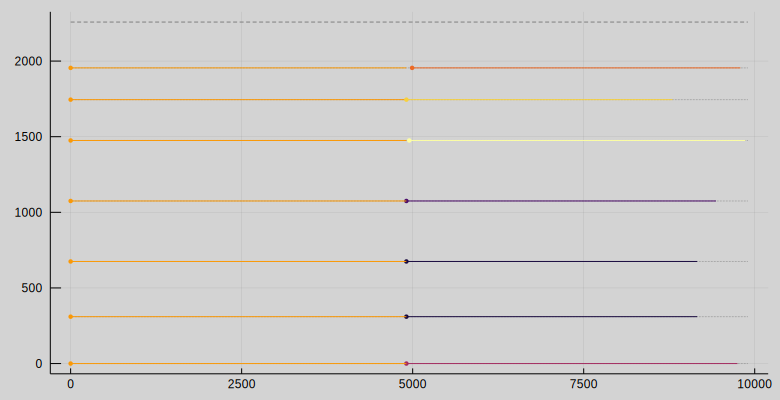

In [40]:
block_allocation(shelves, blocks, H_s, W_s, b_bs, x_bs, z_bs)

## Fix-and-Optimize Heuristic

In [41]:
model3 = fix_and_optimize(
    products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p,
    P_ps, D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s,
    H_p, SL, value.(model2.obj_dict[:z_bs]), empty_space_penalty,
    shortage_penalty, shelf_up_down_penalty);

In [42]:
optimize!(model3, with_optimizer(
    Gurobi.Optimizer,
    TimeLimit=60,
    MIPFocus=3,
    MIPGap=false))

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 6108 rows, 2640 columns and 25100 nonzeros
Variable types: 641 continuous, 1999 integer (452 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+04]
  Objective range  [7e-03, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 4936 rows and 1491 columns
Presolve time: 0.01s
Presolved: 1172 rows, 1149 columns, 5894 nonzeros
Variable types: 81 continuous, 1068 integer (368 binary)
Found heuristic solution: objective 85281.467000
Presolve removed 236 rows and 201 columns
Presolved: 936 rows, 948 columns, 4811 nonzeros


Root relaxation: objective 6.124804e+03, 671 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6124.80365    0  146 85281.4670 6124.80365  92.8%     -    0s
H    0     0 

In [43]:
variables = Dict(k => value.(v) for (k, v) in model3.obj_dict)
n_ps = variables[:n_ps]
s_p = variables[:s_p]
o_s = variables[:o_s]
b_bs = variables[:b_bs]
x_bs = variables[:x_bs]
z_bs = variables[:z_bs];

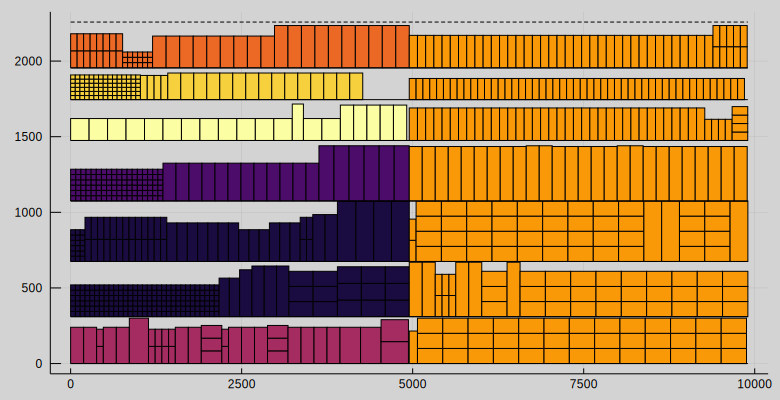

In [44]:
p1 = planogram(products, shelves, blocks, P_b, H_s, H_p, W_p, W_s, SK_p, n_ps, o_s, x_bs)

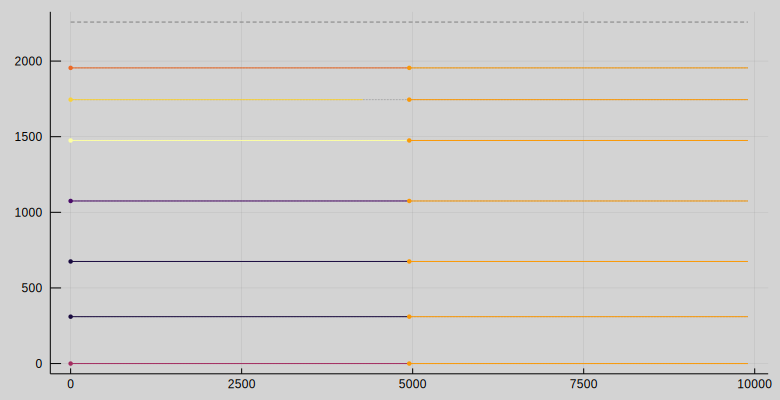

In [45]:
p2 = block_allocation(shelves, blocks, H_s, W_s, b_bs, x_bs, z_bs)

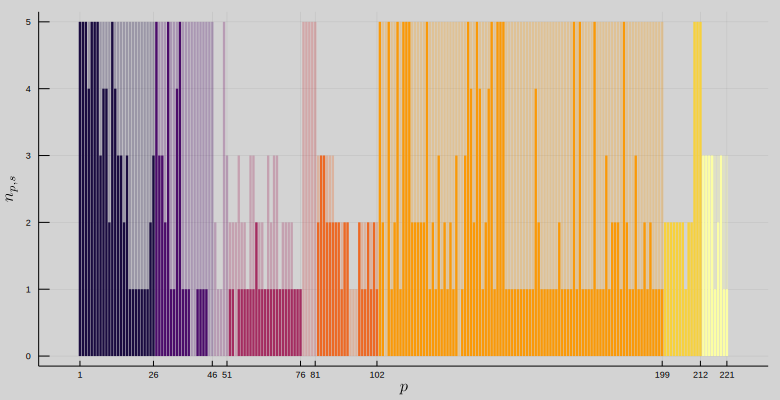

In [46]:
p3 = product_facings(products, shelves, blocks, P_b, N_p_max, n_ps)

In [47]:
# FIXME
# p4 = demand_and_sales(blocks, P_b, D_p, s_p)

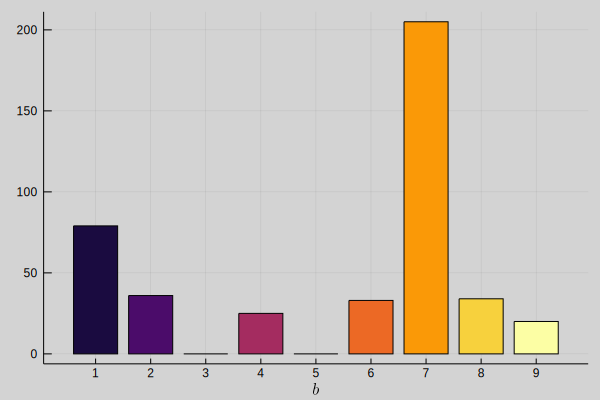

In [48]:
p5 = fill_amount(shelves, blocks, P_b, n_ps)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


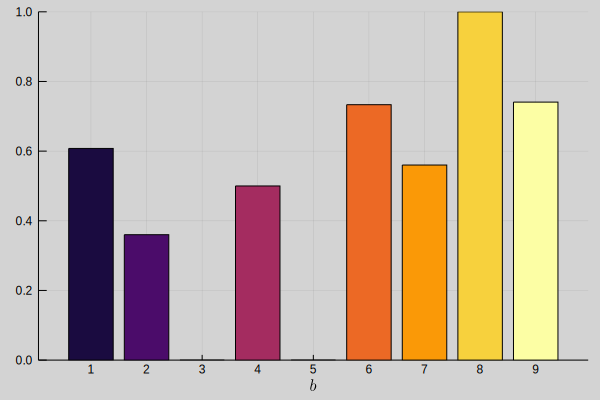

In [49]:
p6 = fill_percentage(
    n_ps, products, shelves, blocks, modules, P_b, S_m, G_p, H_s, L_p, P_ps,
    D_p, N_p_min, N_p_max, W_p, W_s, M_p, M_s_min, M_s_max, R_p, L_s, H_p,
    with_optimizer(Gurobi.Optimizer, TimeLimit=60, LogToConsole=false))